In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# Classifies whether a user has logged into the app on three seperate occasions within seven days.
def adopted_users(df):
    
    user_adoption = {}
    
    user_ids = set(df.object_id.values)
    
    for user in user_ids:
        
        df_user = df[df.object_id==user]
        
        logins = 0
        
        previous_login = None
        
        for time in df_user.time_stamp:
            
            if previous_login:
                
                if (time.month - previous_login.month) == 0 and (time.day - previous_login.day) < 7:
                    
                    logins += 1
                    
                    if logins >= 3:
                        
                        user_adoption[user] = 1
                else:
                    
                    logins = 1
                    
            previous_login = time
                    
        if user not in user_adoption:
            
            user_adoption[user] = 0
            
    return user_adoption

In [3]:
# Determines each feature's correlation to the adopted user target variable.
def feature_target_correlation(df):
    
    features = df.values[:,:-1]
    targets = df.values[:,-1].reshape(len(features),1)
    num = np.mean((features-features.mean(axis=0))*(targets-targets.mean(axis=0)),axis=0)
    denom = features.std(axis=0,dtype=float)*targets.std(axis=0,dtype=float)
    correlation = num/denom
    np.nan_to_num(correlation,0)
    df = pd.DataFrame(correlation,index=df.columns[:-1],columns=['Target Correlation'])
    df = df.sort_values(df.columns[0],axis=0,ascending=False)
    
    return df

In [4]:
# Determines each feature's correlation to all other features.
def feature_correlation(df):
    
    rows = len(df)
    columns = list(df.columns[:-1])
    features = df.values[:,:-1]
    cols = features.shape[1]
    correlation = np.zeros((cols,cols))
    for col in range(cols):
        num = np.mean((features-features.mean(axis=0))*(features[:,col]-features[:,col].mean(axis=0))\
                      .reshape(rows,1),axis=0)
        denom = features[:,col].std()*features.std(axis=0,dtype=float)
        feature_corr = num/denom
        np.nan_to_num(feature_corr,0)
        correlation[col] = feature_corr
    corr_cols = df.columns[:-1]
    corr_cols_idx = range(cols)
    df_corr = pd.DataFrame(correlation,columns=corr_cols,index=corr_cols)
    fig,ax = plt.subplots()
    fig.set_size_inches(100,100)
    ax.imshow(correlation)
    ax.set_xticks(corr_cols_idx)
    ax.set_yticks(corr_cols_idx)
    ax.set_xticklabels(corr_cols)
    ax.set_yticklabels(corr_cols)
    plt.setp(ax.get_xticklabels(),fontsize=32, rotation=90)
    plt.setp(ax.get_yticklabels(),fontsize=32)
    plt.show()

    return df_corr,ax

In [5]:
# One hot encodes account creation time along with login time stamps for months and days.
def one_hot(df):
    
    samples = len(df)

    creation_month = time_stamp_month = np.zeros((samples,12))
    creation_day = time_stamp_day = np.zeros((samples,31))

    creation_month_idx = []
    creation_day_idx = []

    time_stamp_month_idx = []
    time_stamp_day_idx = []

    for idx in range(samples):

        creation_month_idx.append(df.creation_time.iloc[idx].month-1)
        creation_day_idx.append(df.creation_time.iloc[idx].day-1)

        time_stamp_month_idx.append(df.time_stamp.iloc[idx].month-1)
        time_stamp_day_idx.append(df.time_stamp.iloc[idx].day-1)

    creation_month[np.arange(samples),creation_month_idx] = 1
    creation_day[np.arange(samples),creation_day_idx] = 1

    time_stamp_month[np.arange(samples),time_stamp_month_idx] = 1
    time_stamp_day[np.arange(samples),time_stamp_day_idx] = 1

    data = np.concatenate([creation_month,creation_day,time_stamp_month,time_stamp_day],axis=1)
    columns = ['creation_Jan','creation_Feb','creation_Mar','creation_Apr','creation_May','creation_Jun','creation_Jul',\
               'creation_Aug','creation_Sep','creation_Oct','creation_Nov','creation_Dec'] + \
              ['creation_day' + str(idx+1) for idx in range(31)] + ['time_stamp_Jan','time_stamp_Feb','time_stamp_Mar',\
               'time_stamp_Apr','time_stamp_May','time_stamp_Jun','time_stamp_Jul','time_stamp_Aug','time_stamp_Sep',\
               'time_stamp_Oct','time_stamp_Nov','time_stamp_Dec'] + ['time_stamp_day' + str(idx+1) for idx in range(31)]

    return pd.DataFrame(data,columns=columns)

In [6]:
# Logistic Regression Model.
def logistic_model(df):
    
    X = df.values[:,:-1]
    Y = df.values[:,-1]
    
    xtr,xte,ytr,yte = train_test_split(X,Y,test_size=.2,stratify=Y)
    
    model = LogisticRegression()
    model.fit(xtr,ytr)
    
    return model.score(xte,yte)

In [7]:
df_engagement = pd.read_csv('takehome_user_engagement.csv')

In [8]:
df_engagement = df_engagement.dropna()

In [9]:
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
fh = open('takehome_users.csv','rb')

In [11]:
lines = []

In [12]:
idx_list = []

In [13]:
for idx,line in enumerate(fh):
    
    if idx == 0:
        
        columns = line.decode().strip('\n').strip('\r').split(',')
        
    else:
        
        try:
            
            lines.append(line.decode().strip('\n').strip('\r').split(','))
            
        except:
            
            idx_list.append(idx)

In [14]:
df_users = pd.DataFrame(lines,columns=columns)

In [15]:
df_users = df_users.dropna()

In [16]:
missing_values = [len(df_users[df_users[col]== '']) for col in df_users.columns]

In [17]:
missing_values

[0, 0, 0, 0, 0, 3021, 0, 0, 0, 5329]

In [18]:
missing_value_cols = df_users.columns[np.nonzero(missing_values)[0]]

In [19]:
missing_value_cols

Index(['last_session_creation_time', 'invited_by_user_id'], dtype='object')

In [20]:
df_users = df_users.drop(missing_value_cols,axis=1)

In [21]:
df_users.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193


In [22]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.3+ MB


In [23]:
columns = list(df_engagement.columns)
columns.remove('user_id')
columns.insert(1,'object_id')
df_engagement.columns = columns

In [24]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11422 entries, 0 to 11421
Data columns (total 8 columns):
object_id                     11422 non-null object
creation_time                 11422 non-null object
name                          11422 non-null object
email                         11422 non-null object
creation_source               11422 non-null object
opted_in_to_mailing_list      11422 non-null object
enabled_for_marketing_drip    11422 non-null object
org_id                        11422 non-null object
dtypes: object(8)
memory usage: 803.1+ KB


In [25]:
df_users.object_id = df_users.object_id.astype(int)

In [26]:
df = df_users.merge(df_engagement,on='object_id').drop_duplicates()

In [27]:
df.creation_time = df.creation_time.astype('datetime64')

In [28]:
df.time_stamp = df.time_stamp.astype('datetime64')

In [29]:
user_adoption = adopted_users(df)

In [30]:
df_features = pd.concat([df,pd.get_dummies(df.creation_source)],axis=1)

In [31]:
df_features = pd.concat([df_features,one_hot(df)],axis=1)

In [32]:
df_features['adopted_user'] = np.zeros(len(df))

for user,label in user_adoption.items():
    
    df_features.adopted_user[df.object_id==user] = label

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [33]:
df_features = df_features.drop(['creation_source','object_id','creation_time','name','email','org_id',\
                                'time_stamp'],axis=1)

In [34]:
df_features['opted_in_to_mailing_list'] = df['opted_in_to_mailing_list'].astype(int)

In [35]:
df_features['enabled_for_marketing_drip'] = df['enabled_for_marketing_drip'].astype(int)

In [36]:
all_features = logistic_model(df_features)

In [37]:
all_features

0.96415651908085798

In [38]:
df_target_correlation = feature_target_correlation(df_features)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [39]:
df_target_correlation

,Target Correlation
time_stamp_Jun,0.056228
creation_Jun,0.056228
time_stamp_Aug,0.054688
creation_Aug,0.054688
time_stamp_Oct,0.049341
creation_Oct,0.049341
time_stamp_Jul,0.048756
creation_Jul,0.048756
creation_Sep,0.045663
time_stamp_Sep,0.045663


In [40]:
df_features = df_features.drop(df_target_correlation[df_target_correlation['Target Correlation']<=0].index,axis=1)

In [41]:
df_target_correlation = feature_target_correlation(df_features)

In [42]:
target_correlation_drop = logistic_model(df_features)

In [43]:
target_correlation_drop

0.9544759769704998

In [44]:
pca = PCA()

In [45]:
pca.fit_transform(df_features.values[:,:-1])

array([[ -1.68252003e-01,  -4.08750996e-01,   1.12557511e+00, ...,
         -2.11474132e-15,  -7.83129661e-16,  -6.00952222e-17],
       [ -3.76650637e-02,  -2.21392943e-01,  -6.55228157e-03, ...,
          2.35765260e-15,   5.66149380e-16,  -3.26368738e-18],
       [ -4.44130589e-02,  -2.06477029e-01,   1.63922903e-02, ...,
          7.58704392e-16,  -3.28665910e-16,  -3.43760200e-16],
       ..., 
       [  6.71318570e-02,  -6.83831696e-02,  -1.87776027e-01, ...,
          5.19961140e-18,   1.41061234e-17,  -2.34065293e-17],
       [ -8.97309909e-02,  -5.24548298e-01,   1.19740528e+00, ...,
          4.67716130e-17,  -6.86362077e-17,  -3.52290856e-17],
       [  1.17114760e+00,   4.72461281e-01,   1.81257313e-01, ...,
         -9.74650991e-18,   1.20686118e-17,   5.51491106e-18]])

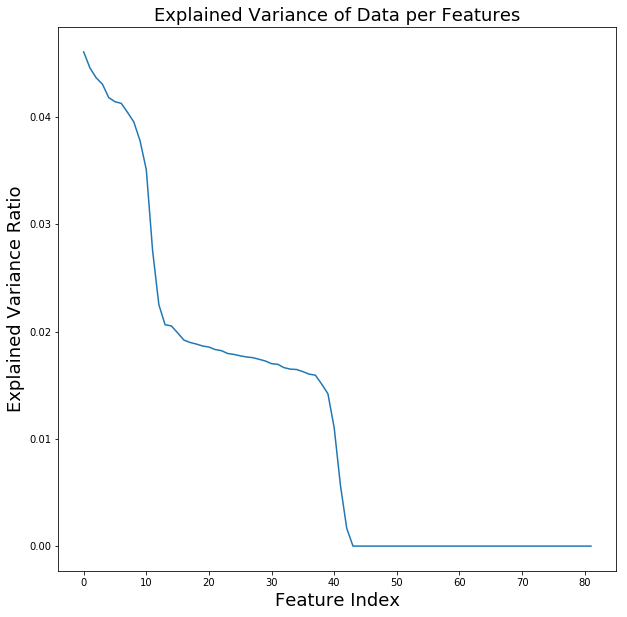

In [46]:
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
ax.plot(pca.explained_variance_ratio_)
ax.set_title('Explained Variance of Data per Features',fontsize=18)
ax.set_xlabel('Feature Index',fontsize=18)
ax.set_ylabel('Explained Variance Ratio',fontsize=18)
plt.show()

In [47]:
pca = PCA(37)

In [48]:
df_pca = pd.DataFrame(pca.fit_transform(df_features.values[:,:-1]))

In [49]:
df_pca = pd.concat([df_pca,df_features[[df_features.columns[-1]]]],axis=1)

In [50]:
pca_drop = logistic_model(df_pca)

In [51]:
pca_drop

0.95271819432414528

In [52]:
pca = PCA(12)

In [53]:
df_pca = pd.DataFrame(pca.fit_transform(df_features.values[:,:-1]))

In [54]:
df_pca = pd.concat([df_pca,df_features[[df_features.columns[-1]]]],axis=1)

In [55]:
pca_drop = logistic_model(df_pca)

In [56]:
pca_drop

0.95271819432414528

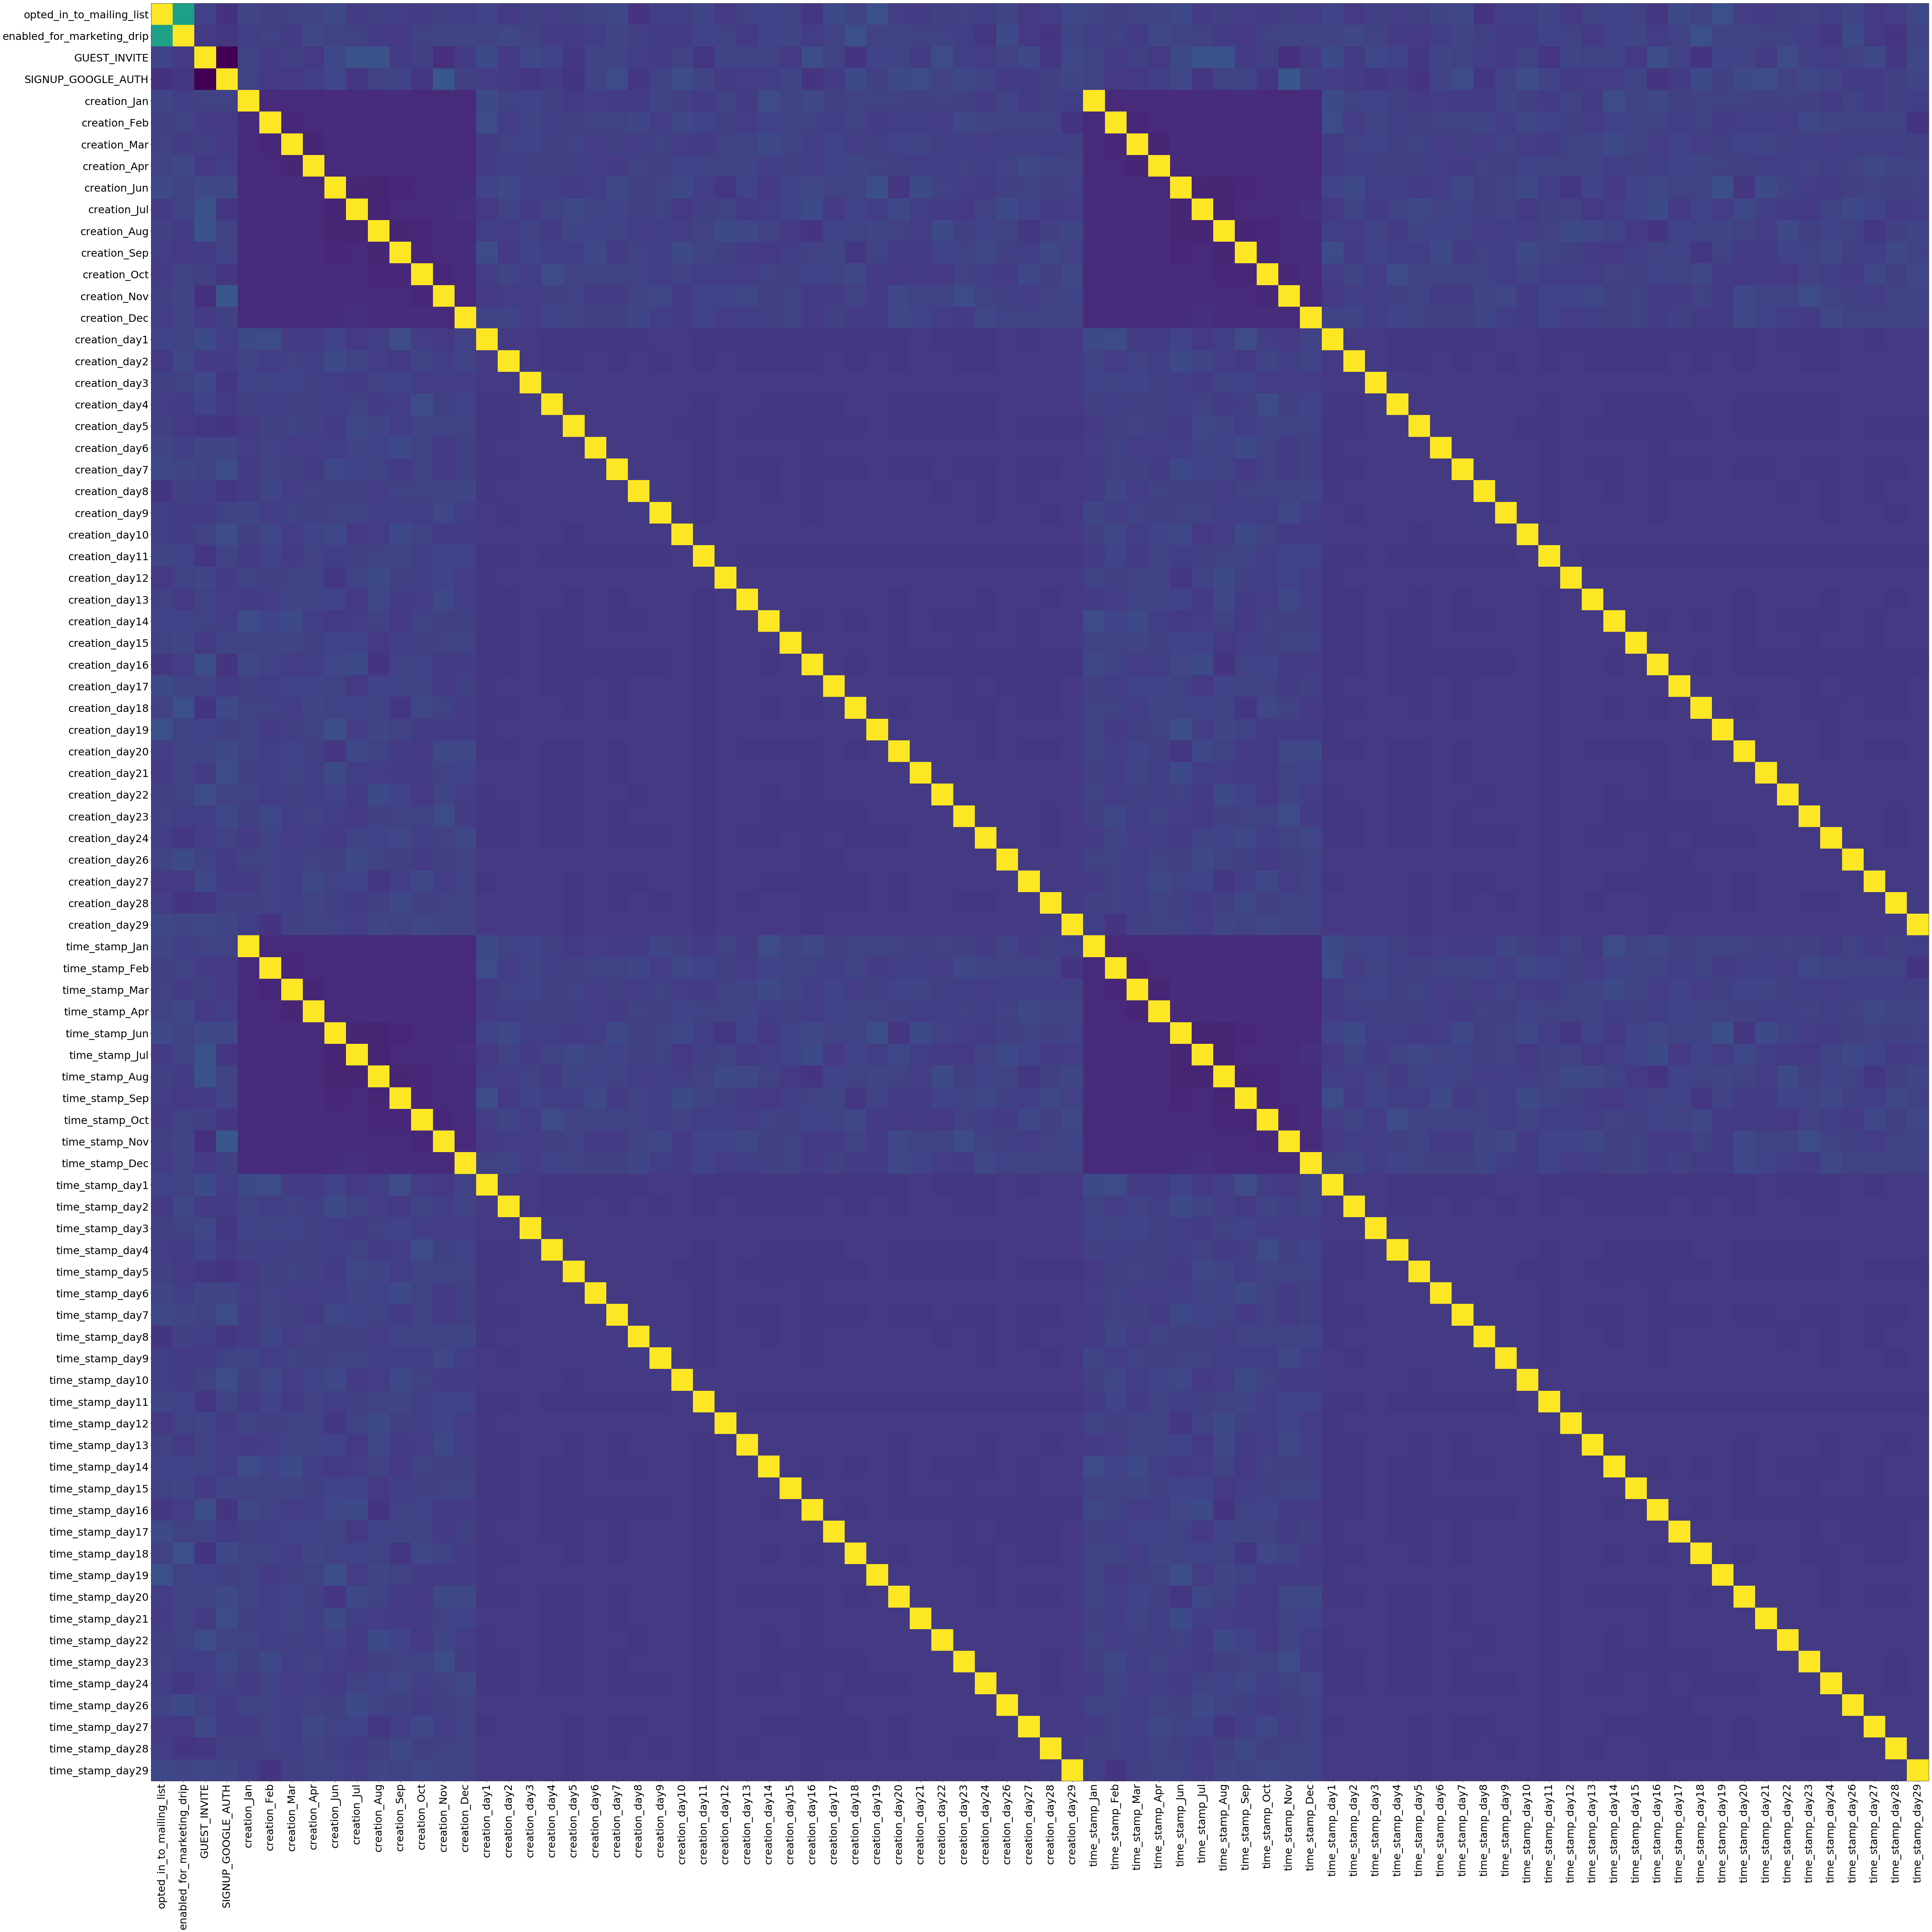

In [57]:
df_correlation,ax_correlation = feature_correlation(df_features)

In [58]:
time_stamps = [time for time in df_target_correlation.index if time.startswith('time_stamp')]

In [59]:
time_stamp_correlation_avg = np.mean(df_target_correlation.loc[time_stamps].values)

In [60]:
time_stamp_correlation_avg

0.018230146328640087

In [61]:
creation_time = [time for time in df_target_correlation.index if time.startswith('creation')]

In [62]:
creation_time_correlation_avg = np.mean(df_target_correlation.loc[creation_time].values)

In [63]:
creation_time_correlation_avg

0.018230146328640087

In [64]:
df_features = df_features.drop(time_stamps,axis=1)

In [65]:
df_target_correlation.loc[['enabled_for_marketing_drip','opted_in_to_mailing_list']]

,Target Correlation
enabled_for_marketing_drip,0.004835
opted_in_to_mailing_list,0.005833


In [66]:
df_features = df_features.drop(['enabled_for_marketing_drip'],axis=1)

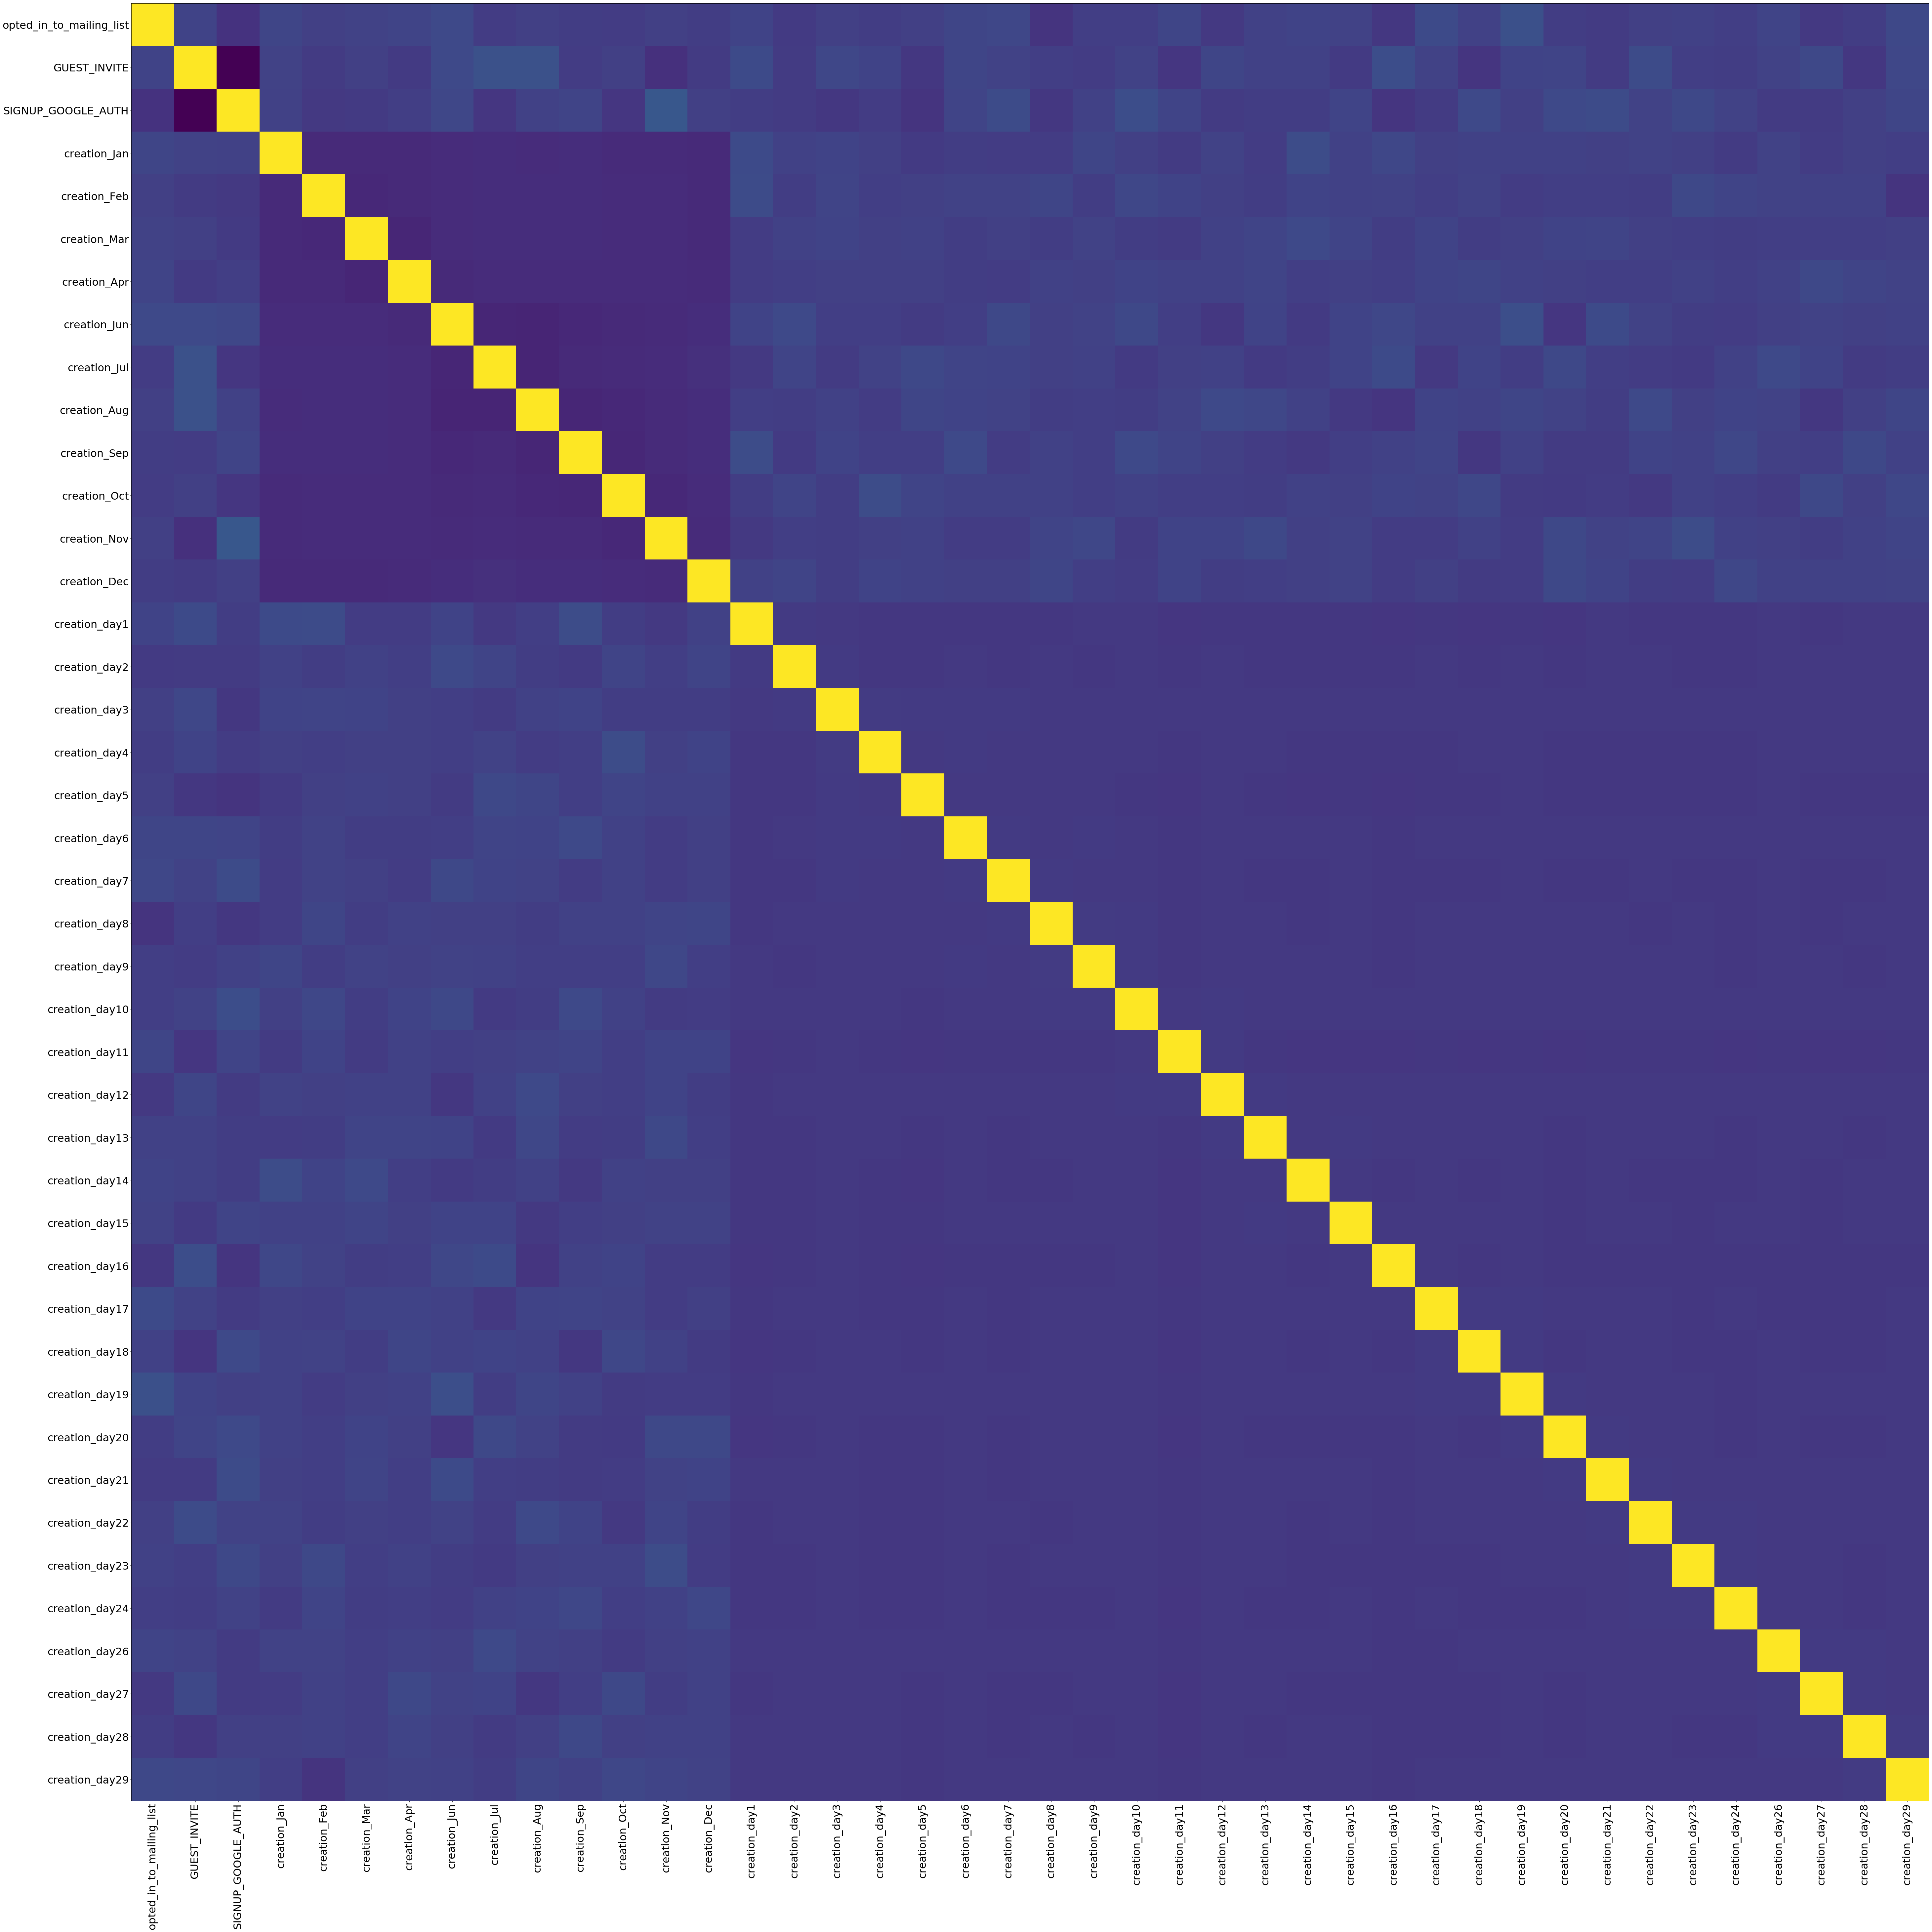

In [67]:
df_correlation,ax_correlation = feature_correlation(df_features)

In [68]:
correlated_features_drop = logistic_model(df_features)

In [69]:
correlated_features_drop

0.9539155245325317

In [70]:
# Feature importance was determined via feature target correlation, feature correlation, and model variance 
# per feature. These metrics were achieved by calculating the correlation of features compared with other features
# and targets along with determining the amount of variance contributed to the overall model through
# principal component analysis. Initially, last_session_creation_time and invited_by_user_id were dropped
# due to the volume of missing values. After doing so, a logistic regression model was fitted and scored
# ~96.4 % accuracy. After doing so, features with negative target correlation were dropped and another
# model was fitted and scored ~95.4 %. Following this principal component analysis was performed
# and plotted against feature count to determine feature importance. Both thirty-seven and twelve features were
# utilized with pca to fit and score models resulting in 95.7 % each time. Finally, feature correlation was
# computed against other features. The only correlated values were enabled_for_marketing_drip and 
# opted_in_to_mailing_list. Enabled_for_marketing_drip was dropped due to it having a lower correlation with
# the targets. The resulting model scored ~ 95.4 %.